# URL Attention Exploration

In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, GRU, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
from sklearn.model_selection import train_test_split
import numpy as np
from attn_utils import *
import matplotlib.pyplot as plt
from URL712 import plot_cm, make_ndir
from LSTMURL import RocAucEvaluation
%matplotlib inline

Using TensorFlow backend.
/home/lam/anaconda2/envs/url712_py3/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/lam/anaconda2/envs/url712_py3/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
read = 'last'
# read = 'front'

In [3]:
method = 'char'
# method = 'class'
units = 64
bi_units = 32
length = 10
n_epoch = 1

In [4]:
modeltype = 'LSTM'
# modeltype = 'GRU'

# training data
dataset, url_v, label_v, inv_label_v = load_dataset()

# test data
test_X, test_Y = load_testset()

In [5]:
print('URL vocab', url_v)

('URL vocab', {' ': 0, '$': 3, '(': 7, ',': 11, '0': 15, '4': 19, '8': 23, '<': 27, '@': 31, 'D': 35, 'H': 39, 'L': 43, 'P': 47, 'T': 51, 'X': 55, '\\': 59, '`': 63, 'd': 67, 'h': 71, 'l': 75, 'p': 79, 't': 83, 'x': 87, '|': 91, "'": 6, '+': 10, '/': 14, '3': 18, '7': 22, ';': 26, '?': 30, 'C': 34, 'G': 38, 'K': 42, 'O': 46, 'S': 50, 'W': 54, '[': 58, '_': 62, 'c': 66, 'g': 70, 'k': 74, 'o': 78, 's': 82, 'w': 86, '{': 90, '<unk>': 94, '"': 2, '&': 5, '*': 9, '.': 13, '2': 17, '6': 21, ':': 25, '>': 29, 'B': 33, 'F': 37, 'J': 41, 'N': 45, 'R': 49, 'V': 53, 'Z': 57, '^': 61, 'b': 65, 'f': 69, 'j': 73, 'n': 77, 'r': 81, 'v': 85, 'z': 89, '~': 93, '<pad>': 95, '!': 1, '%': 4, ')': 8, '-': 12, '1': 16, '5': 20, '9': 24, '=': 28, 'A': 32, 'E': 36, 'I': 40, 'M': 44, 'Q': 48, 'U': 52, 'Y': 56, ']': 60, 'a': 64, 'e': 68, 'i': 72, 'm': 76, 'q': 80, 'u': 84, 'y': 88, '}': 92})


In [6]:
print('URL vocab', label_v)

('URL vocab', {'+': 0, '-': 1})


In [7]:
print('URL vocab', inv_label_v)

('URL vocab', {0: '+', 1: '-'})


In [ ]:
# Tx length of substring
Tx = length
Ty = 1
X, Y, Xoh, Yoh = preprocess_data(dataset, url_v, label_v, Tx, Ty,read, method)

In [9]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx) #<Gema> Repeats the input Tx times.
concatenator = Concatenate(axis=-1) #<Gema> Layer that concatenates a list of inputs. axis: Axis along which to concatenate, in this case, on the last axis.
densor1 = Dense(10, activation = "tanh") #<Gema> Just your regular densely-connected NN layer.
#<Gema> Dense implements the operation: output = activation(dot(input, kernel) + bias) where kernel is a weights matrix created by the layer
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
#<Gema> Applies an activation function to an output.
dotor = Dot(axes = 1) 
#<Gema> Layer that computes a dot product between samples in two tensors.

In [10]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """
       
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([a,s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas,a])
    
    return context

In [11]:
n_a = bi_units

# n_s: num of units
n_s = units
if modeltype == 'LSTM':
    post_activation_LSTM_cell = LSTM(n_s, return_state = True)
elif modeltype == 'GRU':
    post_activation_LSTM_cell = GRU(n_s, return_state = True)
output_layer = Dense(len(label_v), activation=softmax)

In [13]:
model = build_attention(Tx, Ty, n_a, n_s, len(url_v), len(label_v))

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 96)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 10, 64)       33024       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 10, 64)       0           s0[0][0]                         
__________________________________________________________________________________________________
concatenat

In [15]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
outputs = list(Yoh.swapaxes(0,1))

In [17]:
# create validation set

m = len(dataset)
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
# xtrain, xval, ytrain, yval = train_test_split([Xoh,s0,c0], outputs, test_size=0.1,random_state=7)
# xtrain, xval, ytrain, yval = train_test_split(Xoh, outputs, test_size=0.1,random_state=7)

In [18]:
# model.fit([xtrain, s0, c0], ytrain, epochs=n_epoch, batch_size=100, verbose=2, validation_data=(xval,yval))

In [19]:
model.fit([Xoh, s0, c0], outputs, epochs=n_epoch, batch_size=100,validation_data=([Xoh, s0, c0], outputs))
model.save_weights('attn_models/2epoch.h5')
# model.load_weights('attn_models/1epoch.h5')

Train on 50000 samples, validate on 50000 samples
Epoch 1/1
50000/50000 [==============================] - 21s 415us/step - loss: 0.1820 - acc: 0.9443 - val_loss: 0.1644 - val_acc: 0.9481


In [ ]:
predicted_mc = []
for example in test_X[:10000]:
    
    source = string_to_int(example, Tx, url_v, read, method)
#     source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(url_v)), source)))
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_label_v[int(i)] for i in prediction]
    predicted_mc.append(output)

Attention Predict Units:64 URL:10000 char:10 w:- AUC:0.618


/home/lam/anaconda2/envs/url712_py3/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


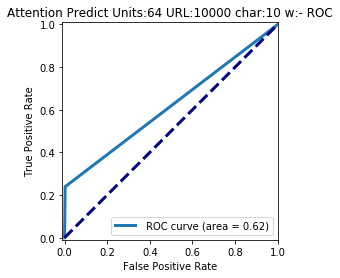

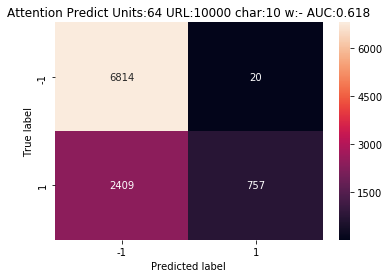

In [21]:
round_fun = lambda x: ['1'] if x == '+' else ['0']
y_predict = np.apply_along_axis(round_fun, 1, predicted_mc)
y_true = np.apply_along_axis(round_fun, 1, test_Y[:10000])
make_ndir('attn')
plot_cm(y_predict, '%s %s Units:%d URL:%d char:%d w:%s' % ('Attention', 'Predict', n_s, len(y_true), Tx ,'-' ), y_true, ['-1', '1'])

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 96)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 10, 64)       33024       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 10, 64)       0           s0[0][0]                         
__________________________________________________________________________________________________
concatenat